#### Reading the data 

In [143]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 

data = pd.read_csv('data/poly_mo/quant_bootstraps.tsv', header=0, sep='\t')

truth = pd.read_csv('data/poly_mo/poly_truth.tsv', header=0, index_col=0, sep='\t')

quant = pd.read_csv('data/poly_mo/quant.sf', header=0, index_col=0, sep='\t')



Computing basic statistics for each transcript

In [144]:
import math
data = data.apply(lambda x: np.sort(x.values))

lower_bounds = data.apply(lambda values: values[int(math.ceil(0.025*len(values)))])
upper_bounds = data.apply(lambda values: values[int(math.floor(0.975*len(values)))])
data_mins = data.min()
data_maxs = data.max()
data_means = data.mean()
data_std = data.std()

data = data.transpose()

data['lower_bound'] = lower_bounds
data['upper_bound'] = upper_bounds
data['min'] = data_mins
data['max'] = data_maxs
data['mean'] = data_means
data['std'] = data_std

Merging with ground truth

In [145]:
data['truth'] = truth

data = data[~data['truth'].isnull()]

Filtering out erroneous transcripts

In [146]:
# data['erroneous'] = data.apply(
#     lambda x: (x['truth'] < x['min']) or (x['max'] < x['truth']), axis=1)


# data['erroneous'] = data.apply(
#     lambda x: ((x['mean']-(2*x['std'])) < x['truth'] ) and (x['truth'] < (x['mean']+(2*x['std']))), axis=1)


data['erroneous'] = data.apply(
    lambda x: (x['truth'] < x['lower_bound']) or (x['upper_bound'] < x['truth']), axis=1)

Percentage of rows that are erroneous:

In [147]:
print "Percentage of erroneous rows: %s" % \
    (float(sum(data['erroneous'])*100)/data.shape[0])

Percentage of erroneous rows: 50.2547510134


Assigning properties available in quant.sf file to transcripts:

In [148]:
data['Length'] = quant['Length']
data['EffectiveLength'] = quant['EffectiveLength']
data['TPM'] = quant['TPM']
data['NumReads'] = quant['NumReads']

In [149]:
lines = []
with open('data/poly_mo/eq_classes.txt') as f:
    lines = f.readlines()

lines = [line.replace('\n', '') for line in lines]

transcripts_count = int(lines[0])
data_count = int(lines[1])

transcripts = lines[2:transcripts_count+2]
classes = lines[transcripts_count+2:]

classes = [datum.split('\t') for datum in classes]

In [150]:
all_ts = [[int(transcript_idx), int(eclass[0]), int(eclass[-1])] for eclass in classes for transcript_idx in eclass[1:-1]]

In [151]:
eq_sharecounts_dict = {}
eq_weightedreads_dict = {}
for eq_counts in all_ts:
    if eq_sharecounts_dict.has_key(eq_counts[0]):
        count = eq_sharecounts_dict[eq_counts[0]] + eq_counts[1]
        weighted_reads = eq_weightedreads_dict[eq_counts[0]] + eq_counts[2]/eq_counts[1]
        eq_sharecounts_dict[eq_counts[0]] = count
        eq_weightedreads_dict[eq_counts[0]] = weighted_reads
    else:
        eq_sharecounts_dict[eq_counts[0]] = eq_counts[1]
        eq_weightedreads_dict[eq_counts[0]] = eq_counts[2]/eq_counts[1]

In [152]:
ts_eshare_counts = pd.DataFrame(eq_sharecounts_dict.values(), index=eq_sharecounts_dict.keys(), columns=["Share_Counts"])

In [153]:
ts_wreads_counts = pd.DataFrame(eq_weightedreads_dict.values(), index=eq_weightedreads_dict.keys(), columns=["W_Reads"])

In [154]:
merged = pd.merge(ts_eshare_counts, ts_wreads_counts, left_index=True, right_index=True)

In [155]:
transcripts = pd.DataFrame(transcripts, columns=['transcript'])
merged2 = pd.merge(merged, transcripts, left_index=True, right_index=True)

In [156]:
merged2.index = merged2['transcript']; del merged2['transcript']

In [163]:
# data.head()
# merged2.head()
# print len(data)
# print len(merged2)
data['AssocEquivClasses'] = merged2['Share_Counts']
data['WeightedReads'] = merged2['W_Reads']
print len(data)
data.head(500)

26889


,0,1,2,3,4,5,6,7,8,9,...,mean,std,truth,erroneous,Length,EffectiveLength,TPM,NumReads,AssocEquivClasses,WeightedReads
ENST00000608495,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,1.0,True,1672,1472.991,0.000000,0.000000,NaN,NaN
ENST00000382369,19.272902,21.122520,2.175481e+01,2.243759e+01,2.267404e+01,2.382209e+01,2.434825e+01,2.438703e+01,2.578533e+01,2.601768e+01,...,45.651584,12.636180,55.0,False,1420,1220.991,1.180968,46.855146,6.0,52.0
ENST00000360321,13.465284,15.456381,1.662551e+01,1.726975e+01,1.904439e+01,1.979250e+01,2.037474e+01,2.060514e+01,2.091051e+01,2.126411e+01,...,41.580917,11.378288,54.0,False,1575,1375.991,0.912080,40.780781,8.0,55.0
ENST00000400269,40.970483,45.874537,4.615453e+01,4.627200e+01,4.788634e+01,4.815006e+01,4.858384e+01,5.032616e+01,5.208490e+01,5.335841e+01,...,70.977499,10.912630,92.0,False,1022,822.991,2.705958,72.364073,6.0,52.0
ENST00000382352,1921.000000,1928.000000,1.932000e+03,1.940000e+03,1.940000e+03,1.943000e+03,1.943000e+03,1.950000e+03,1.953000e+03,1.961000e+03,...,2035.750000,45.244811,2653.0,True,3229,3029.991,20.638372,2032.000000,1.0,2032.0
ENST00000342665,1886.000000,1896.000000,1.903000e+03,1.905000e+03,1.905000e+03,1.913000e+03,1.916000e+03,1.920000e+03,1.920000e+03,1.920000e+03,...,1996.815000,43.162551,2804.0,True,4627,4427.991,13.886148,1998.000000,3.0,1478.0
ENST00000609179,150.000000,154.000000,1.570000e+02,1.600000e+02,1.620000e+02,1.640000e+02,1.640000e+02,1.650000e+02,1.650000e+02,1.650000e+02,...,183.390000,12.964889,261.0,True,578,379.005,14.940537,184.000000,22.0,92.0
ENST00000217233,215.551894,220.509495,2.218663e+02,2.256904e+02,2.279657e+02,2.295476e+02,2.297635e+02,2.297715e+02,2.339435e+02,2.339882e+02,...,268.623238,20.353776,382.0,True,2499,2299.991,3.581666,267.681402,6.0,309.0
ENST00000449710,177.433780,186.363186,1.906779e+02,1.913185e+02,1.929176e+02,1.961759e+02,1.963455e+02,1.976099e+02,1.985133e+02,1.989834e+02,...,233.963500,20.184732,350.0,True,1070,870.991,8.234501,233.054648,6.0,174.0
ENST00000422053,146.929556,150.305511,1.516072e+02,1.549012e+02,1.555786e+02,1.618159e+02,1.620576e+02,1.631668e+02,1.648823e+02,1.660595e+02,...,198.303262,20.086799,259.0,True,1533,1333.991,4.643081,201.263950,8.0,216.0


In [17]:
from math import log

from matplotlib import pyplot as plt, rc

%matplotlib inline

Comparing distributions of properties of erroneous transcripts with non-erroneous ones

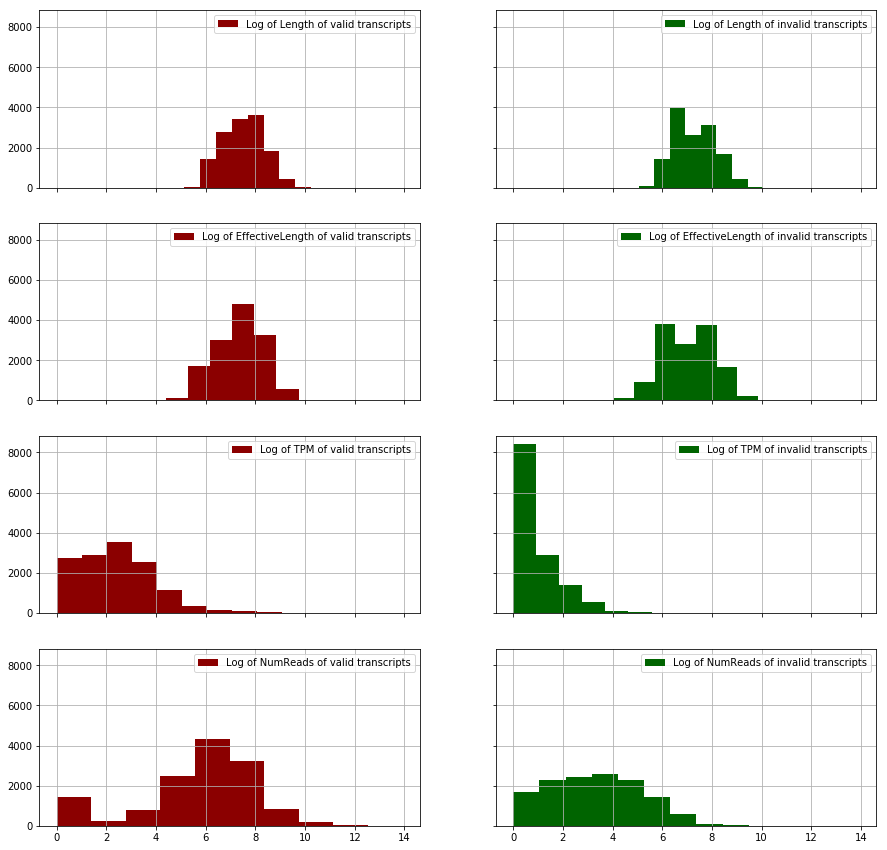

In [18]:
fig, axs = plt.subplots(4,2, sharey=True, sharex=True)
fig.set_size_inches(15,15)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

for i, prop in enumerate(properties):
    ax1 = data[data['erroneous']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i][0], color='darkred')
    ax1.legend(['Log of %s of valid transcripts' % prop])

    ax = data[~data['erroneous']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i][1], color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop])



## Equivalence Classes



Trying to look at the makeup of the equivalence classes in terms of percentage of valid and invalid transcripts:

In [70]:
invalid_ts = list(data[data['erroneous']].index)

In [57]:
lines = []
with open('data/poly_mo/eq_classes.txt') as f:
    lines = f.readlines()

lines = [line.replace('\n', '') for line in lines]

transcripts_count = int(lines[0])
data_count = int(lines[1])

transcripts = lines[2:transcripts_count+2]
classes = lines[transcripts_count+2:]

classes = [datum.split('\t') for datum in classes]

In [72]:
percentages_invalid = []

for eclass in classes:
    invalid_count = 0
    for transcript_idx in eclass[1:-1]:
        if transcripts[int(transcript_idx)] in invalid_ts:
            invalid_count += 1
    percentage_invalid = (invalid_count*100)/float(eclass[0])
    percentages_invalid.append(percentage_invalid)
        

In [88]:
percentages_valid = [100-element for element in percentages_invalid]

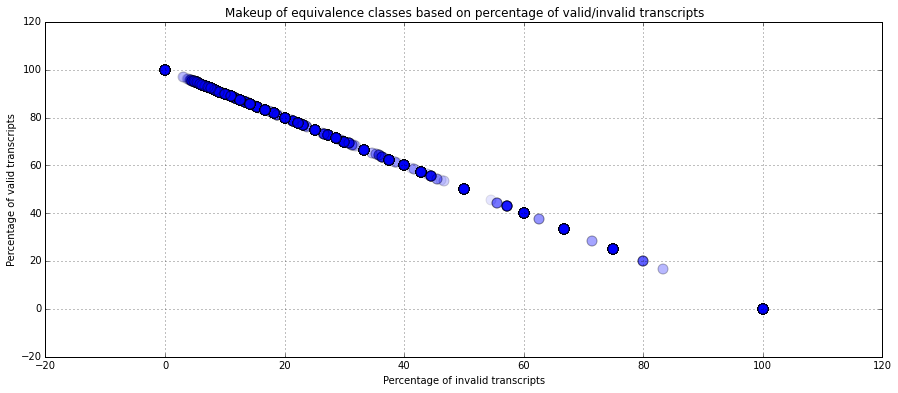

In [122]:
plt.scatter(percentages_invalid, percentages_valid, alpha=0.1, s=100)
plt.grid()
plt.xlabel('Percentage of invalid transcripts')
plt.ylabel('Percentage of valid transcripts')
plt.title("Makeup of equivalence classes based on percentage of valid/invalid transcripts")

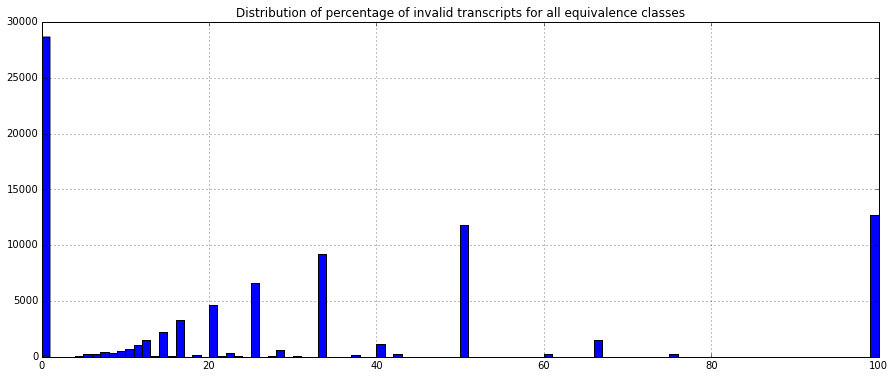

In [123]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.grid()
pd.Series(percentages_invalid).hist(bins=100)
plt.title('Distribution of percentage of invalid transcripts for all equivalence classes')

Creating a new property for each transcript: the number of equivalence classes it belongs to.

In [104]:
all_ts = [int(transcript_idx) for eclass in classes for transcript_idx in eclass[1:-1]]
ts_eclass_counts = pd.DataFrame(pd.Series(all_ts).value_counts(), columns=['eclass_cnt'])

In [106]:
ts_eclass_counts.head(10)

,eclass_cnt
9985,225
9850,189
9853,188
9852,187
9796,168
9988,153
9989,151
9979,150
9978,150
9991,133


In [107]:
transcripts = pd.DataFrame(transcripts, columns=['transcript'])
merged = pd.merge(ts_eclass_counts, transcripts, left_index=True, right_index=True)

In [111]:
transcripts.head()
merged.head()

,eclass_cnt,transcript
9985,225,ENST00000369202
9850,189,ENST00000369339
9853,188,ENST00000605176
9852,187,ENST00000342960
9796,168,ENST00000369365


In [158]:
merged.index = merged['transcript']; del merged['transcript']

In [160]:
data['eclass_cnt'] = merged['eclass_cnt']

In [166]:
data['eclass_cnt'] = data['eclass_cnt'].fillna(0)

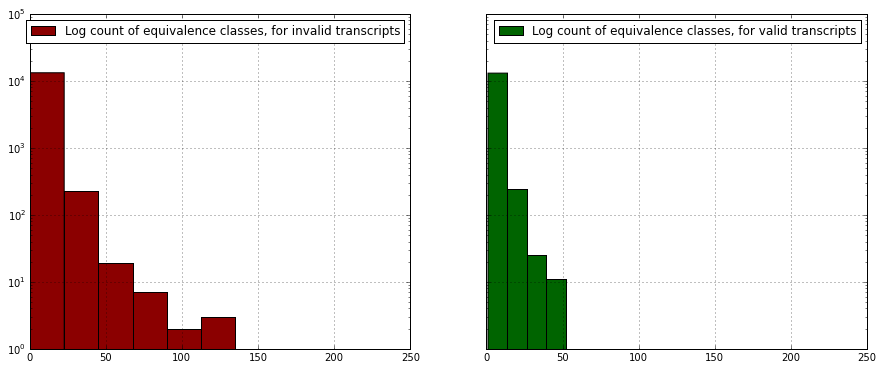

In [177]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
# fig.set_size_inches(15,15)

prop = 'eclass_cnt'

ax1 = data[data['erroneous']][prop].hist(ax=axs[0], log=True, color='darkred')#.apply(lambda x: log(x+1))
ax1.legend(['Log count of equivalence classes, for invalid transcripts'])

ax = data[~data['erroneous']][prop].hist(ax=axs[1], log=True, color='darkgreen')
ax.legend(['Log count of equivalence classes, for valid transcripts'])